# Task 4: Classification with Logistic Regression

**Objective**: Build a binary classifier using logistic regression  
**Tools**: Scikit-learn, Pandas, Matplotlib  
**Dataset**: Breast Cancer Wisconsin Dataset

## Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_curve, auc,
                           precision_recall_curve, roc_auc_score)
import warnings

## Step 1: Choose a Binary Classification Dataset

In [2]:
# Load Dataset
df = pd.read_csv("C:/Users/ADMIN/Downloads/Elevate Labs Tasks/data.csv")
# Dataset overview
print(f"\n DATASET OVERVIEW")
print(f"Dataset Shape: {df.shape}")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(df.columns)}")

# Display first few rows
print(f"\nFirst 5 rows:")
df.head()


 DATASET OVERVIEW
Dataset Shape: (569, 33)
Number of samples: 569
Number of features: 33

First 5 rows:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


TARGET VARIABLE ANALYSIS
Diagnosis Distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64

Class Distribution:
  B: 357 samples (62.7%)
  M: 212 samples (37.3%)

Interpretation:
  M = Malignant (Cancer) - 212 cases
  B = Benign (Not Cancer) - 357 cases


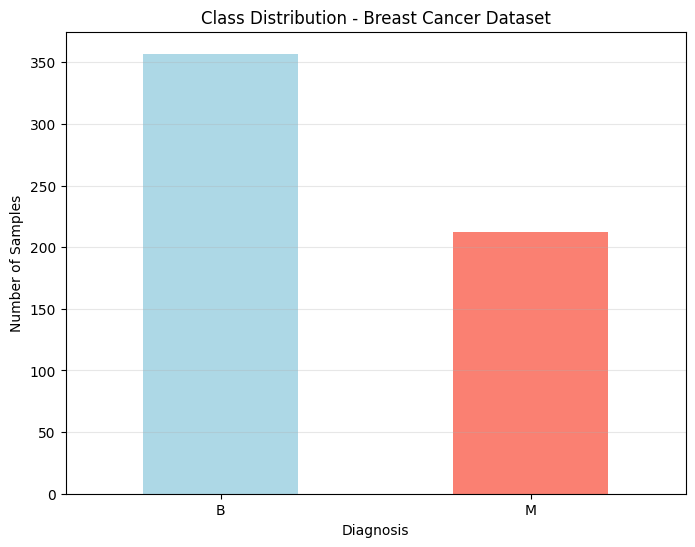

In [3]:
# Analyze target variable (diagnosis)
print(f"TARGET VARIABLE ANALYSIS")
target_counts = df['diagnosis'].value_counts()
print("Diagnosis Distribution:")
print(target_counts)

# Calculate class distribution
print(f"\nClass Distribution:")
for diag, count in target_counts.items():
    percentage = count / len(df) * 100
    print(f"  {diag}: {count} samples ({percentage:.1f}%)")
    
# Interpretation
print(f"\nInterpretation:")
print(f"  M = Malignant (Cancer) - {target_counts['M']} cases")
print(f"  B = Benign (Not Cancer) - {target_counts['B']} cases")

# Plotting class distribution
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Class Distribution - Breast Cancer Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Check data quality

In [4]:

print(f" DATA QUALITY CHECK")

# Missing values analysis
missing_values = df.isnull().sum()
total_missing = missing_values.sum()

if total_missing == 0:
    print("No missing values detected!")
else:
    print(f"Total missing values: {total_missing}")
    print("Missing values by column:")
    print(missing_values[missing_values > 0])

# Data types
print(f"\nData Types Summary:")
print(f"  Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"  Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

# Feature categories
print(f"\nFeature Categories:")
mean_features = [col for col in df.columns if 'mean' in col]
se_features = [col for col in df.columns if 'se' in col]  
worst_features = [col for col in df.columns if 'worst' in col]

print(f"  Mean features: {len(mean_features)} (e.g., radius_mean, texture_mean)")
print(f"  Standard Error features: {len(se_features)} (e.g., radius_se, texture_se)")
print(f"  Worst features: {len(worst_features)} (e.g., radius_worst, texture_worst)")

 DATA QUALITY CHECK
Total missing values: 569
Missing values by column:
Unnamed: 32    569
dtype: int64

Data Types Summary:
  Numerical features: 32
  Categorical features: 1

Feature Categories:
  Mean features: 10 (e.g., radius_mean, texture_mean)
  Standard Error features: 10 (e.g., radius_se, texture_se)
  Worst features: 10 (e.g., radius_worst, texture_worst)


## Data preprocessing pipeline

In [5]:
print(f"DATA PREPROCESSING")

# Remove unnecessary columns
print("Removing unnecessary columns...")
# Remove 'id' (identifier, not predictive) and any columns with all missing values
columns_to_drop = ['id']
if 'Unnamed: 32' in df.columns:
    columns_to_drop.append('Unnamed: 32')

df_clean = df.drop(columns_to_drop, axis=1)
print(f"Removed columns: {columns_to_drop}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# Encode target variable
print(f"\nEncoding target variable...")
print(f"Original values: {df_clean['diagnosis'].unique()}")

# Binary encoding: M (Malignant) = 1, B (Benign) = 0
df_clean['diagnosis'] = df_clean['diagnosis'].map({'M': 1, 'B': 0})
print(f"Encoded values: {df_clean['diagnosis'].unique()}")
print(f"Encoding scheme: M (Malignant) = 1, B (Benign) = 0")

# Separate features and target
X = df_clean.drop('diagnosis', axis=1)
y = df_clean['diagnosis']

print(f"\nFeature-Target Separation:")
print(f"  Feature matrix (X) shape: {X.shape}")
print(f"  Target vector (y) shape: {y.shape}")

# Check class balance
class_ratio = (y == 1).sum() / (y == 0).sum()
print(f"\nClass Balance Analysis:")
print(f"  Benign (0): {(y == 0).sum()} samples ({(y == 0).mean()*100:.1f}%)")
print(f"  Malignant (1): {(y == 1).sum()} samples ({(y == 1).mean()*100:.1f}%)")
print(f"  Class ratio (Malignant/Benign): {class_ratio:.2f}")

if 0.5 <= class_ratio <= 2.0:
    print("Reasonably balanced classes")
else:
    print("Class imbalance detected - may need special handling")

DATA PREPROCESSING
Removing unnecessary columns...
Removed columns: ['id', 'Unnamed: 32']
Dataset shape after cleaning: (569, 31)

Encoding target variable...
Original values: ['M' 'B']
Encoded values: [1 0]
Encoding scheme: M (Malignant) = 1, B (Benign) = 0

Feature-Target Separation:
  Feature matrix (X) shape: (569, 30)
  Target vector (y) shape: (569,)

Class Balance Analysis:
  Benign (0): 357 samples (62.7%)
  Malignant (1): 212 samples (37.3%)
  Class ratio (Malignant/Benign): 0.59
Reasonably balanced classes


## Step 2: Train/Test Split and Standardize Features

In [6]:
# Train-test split with stratification
print(f"TRAIN-TEST SPLIT")

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution in both sets
)

print(f"Dataset Split (80% train, 20% test):")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")

# Verify stratification worked
print(f"\nClass distribution verification:")
print(f"Training set:")
train_dist = y_train.value_counts().sort_index()
for class_val, count in train_dist.items():
    class_name = "Benign" if class_val == 0 else "Malignant"
    percentage = count / len(y_train) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

print(f"Test set:")
test_dist = y_test.value_counts().sort_index()
for class_val, count in test_dist.items():
    class_name = "Benign" if class_val == 0 else "Malignant" 
    percentage = count / len(y_test) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

print("Stratification successful - class distributions maintained")

TRAIN-TEST SPLIT
Dataset Split (80% train, 20% test):
  Training set: 455 samples
  Test set: 114 samples

Class distribution verification:
Training set:
  Benign: 285 (62.6%)
  Malignant: 170 (37.4%)
Test set:
  Benign: 72 (63.2%)
  Malignant: 42 (36.8%)
Stratification successful - class distributions maintained


In [7]:
# Feature standardization
print(f"FEATURE STANDARDIZATION")
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized!")

# Show impact of standardization
print(f"\nStandardization Impact (first 3 features):")
print(f"Before standardization:")
for i, col in enumerate(X_train.columns[:3]):
    mean_orig = X_train.iloc[:, i].mean()
    std_orig = X_train.iloc[:, i].std()
    print(f"  {col}: Mean={mean_orig:.3f}, Std={std_orig:.3f}")

print(f"After standardization:")
for i in range(3):
    mean_scaled = X_train_scaled[:, i].mean()
    std_scaled = X_train_scaled[:, i].std()
    col_name = X_train.columns[i]
    print(f"  {col_name}: Mean={mean_scaled:.3f}, Std={std_scaled:.3f}")

print(f"\nAll features now have mean ≈ 0 and standard deviation ≈ 1")

FEATURE STANDARDIZATION

Features standardized!

Standardization Impact (first 3 features):
Before standardization:
  radius_mean: Mean=14.166, Std=3.579
  texture_mean: Mean=19.418, Std=4.291
  perimeter_mean: Mean=92.216, Std=24.717
After standardization:
  radius_mean: Mean=-0.000, Std=1.000
  texture_mean: Mean=0.000, Std=1.000
  perimeter_mean: Mean=0.000, Std=1.000

All features now have mean ≈ 0 and standard deviation ≈ 1


## Step 3: Fit a Logistic Regression Model

In [8]:
# Create and train logistic regression model
print(f"LOGISTIC REGRESSION MODEL")

# Model initialization
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Increased for convergence
    solver='lbfgs'  # Good for small datasets
)

print("Model Configuration:")
print(f"  Solver: {lr_model.solver}")
print(f"  Max iterations: {lr_model.max_iter}")
print(f"  Random state: {lr_model.random_state}")

# Train the model
print(f"\n Training the model...")
lr_model.fit(X_train_scaled, y_train)
print("Model training completed!")

# Generate predictions
print(f"\nGenerating predictions...")
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Get prediction probabilities
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions generated!")
print(f"Training predictions shape: {y_train_pred.shape}")
print(f"Test predictions shape: {y_test_pred.shape}")
print(f"Probability range: [{y_test_proba.min():.3f}, {y_test_proba.max():.3f}]")

LOGISTIC REGRESSION MODEL
Model Configuration:
  Solver: lbfgs
  Max iterations: 1000
  Random state: 42

 Training the model...
Model training completed!

Generating predictions...
Predictions generated!
Training predictions shape: (455,)
Test predictions shape: (114,)
Probability range: [0.000, 1.000]


Model Coefficients:
Intercept (bias): -0.2430
Number of feature coefficients: 30

Top 5 Most Important Features (highest absolute coefficients):
  1. texture_worst: 1.4341
     → increases probability of malignancy
  2. radius_se: 1.2333
     → increases probability of malignancy
  3. symmetry_worst: 1.0613
     → increases probability of malignancy
  4. concave points_mean: 0.9528
     → increases probability of malignancy
  5. concavity_worst: 0.9114
     → increases probability of malignancy


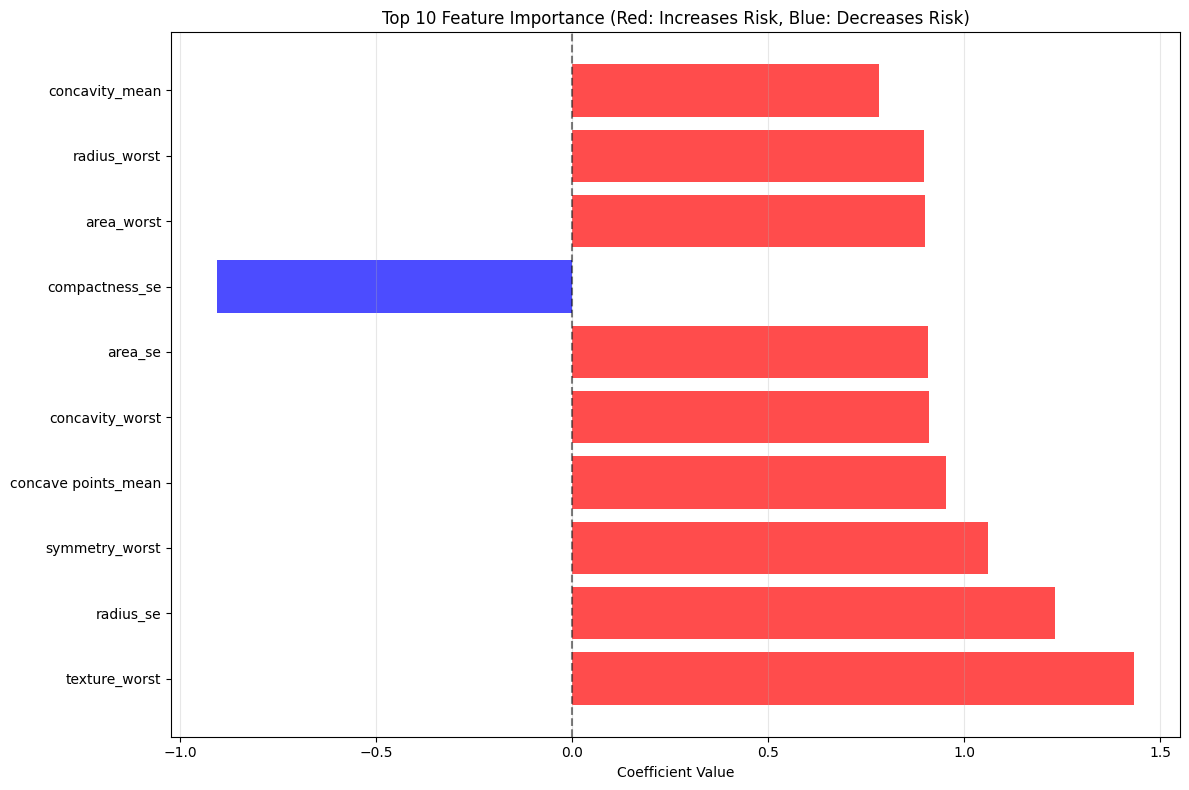

In [9]:
# Analyze model parameters
print(f"Model Coefficients:")
print(f"Intercept (bias): {lr_model.intercept_[0]:.4f}")
print(f"Number of feature coefficients: {len(lr_model.coef_[0])}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 5 Most Important Features (highest absolute coefficients):")
for i, (_, row) in enumerate(feature_importance.head().iterrows(), 1):
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"  {i}. {row['feature']}: {row['coefficient']:.4f}")
    print(f"     → {direction} probability of malignancy")
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
colors = ['red' if coef > 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importance (Red: Increases Risk, Blue: Decreases Risk)')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 4: Evaluate with Confusion Matrix, Precision, Recall, ROC-AUC

In [10]:
# Comprehensive model evaluation
print(f"MODEL EVALUATION")

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    #Calculate and display all evaluation metrics
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.1f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.1f}%)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'roc_auc': roc_auc
    }

# Evaluate both training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Training")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test")

# Performance stability check
stability_gap = train_metrics['accuracy'] - test_metrics['accuracy']
print(f"\nModel Stability Analysis:")
print(f"  Training-Test accuracy gap: {stability_gap:.4f}")

if abs(stability_gap) < 0.05:
    print(" Good: Model shows stable performance")
elif abs(stability_gap) < 0.1:
    print("Moderate: Some overfitting detected")
else:
    print("Concerning: Significant overfitting")

MODEL EVALUATION

Training Set Performance:
Accuracy:  0.9868 (98.7%)
Precision: 1.0000 (100.0%)
Recall:    0.9647 (96.5%)
F1-Score:  0.9820
ROC-AUC:   0.9976

Test Set Performance:
Accuracy:  0.9649 (96.5%)
Precision: 0.9750 (97.5%)
Recall:    0.9286 (92.9%)
F1-Score:  0.9512
ROC-AUC:   0.9960

Model Stability Analysis:
  Training-Test accuracy gap: 0.0219
 Good: Model shows stable performance


## Detailed confusion matrix analysis

In [11]:
print(f"CONFUSION MATRIX ANALYSIS")

def analyze_confusion_matrix(y_true, y_pred, dataset_name):
    #Detailed confusion matrix analysis with clinical interpretation
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{dataset_name} Set Confusion Matrix:")
    print(f"                 Predicted")
    print(f"           Benign  Malignant")
    print(f"Actual    ")
    print(f"Benign      {tn:3d}      {fp:3d}")
    print(f"Malignant   {fn:3d}      {tp:3d}")
    
    print(f"\nDetailed Breakdown:")
    print(f"  True Negatives (TN):  {tn} - Correctly identified benign cases")
    print(f"  False Positives (FP): {fp} - Benign cases misclassified as malignant") 
    print(f"  False Negatives (FN): {fn} - Malignant cases misclassified as benign")
    print(f"  True Positives (TP):  {tp} - Correctly identified malignant cases")
    
    # Clinical interpretation
    print(f"\nClinical Interpretation:")
    print(f"Type I Error (False Positives): {fp} cases")
    
    print(f"Type II Error (False Negatives): {fn} cases") 
    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nDiagnostic Performance:")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")
    print(f"{sensitivity*100:.1f}% of cancer cases correctly identified")
    print(f"Specificity (True Negative Rate): {specificity:.3f}")
    print(f"{specificity*100:.1f}% of healthy cases correctly identified")
    
    return cm, sensitivity, specificity

# Analyze both sets
train_cm, train_sens, train_spec = analyze_confusion_matrix(y_train, y_train_pred, "Training")
test_cm, test_sens, test_spec = analyze_confusion_matrix(y_test, y_test_pred, "Test")

CONFUSION MATRIX ANALYSIS

Training Set Confusion Matrix:
                 Predicted
           Benign  Malignant
Actual    
Benign      285        0
Malignant     6      164

Detailed Breakdown:
  True Negatives (TN):  285 - Correctly identified benign cases
  False Positives (FP): 0 - Benign cases misclassified as malignant
  False Negatives (FN): 6 - Malignant cases misclassified as benign
  True Positives (TP):  164 - Correctly identified malignant cases

Clinical Interpretation:
Type I Error (False Positives): 0 cases
Type II Error (False Negatives): 6 cases

Diagnostic Performance:
Sensitivity (True Positive Rate): 0.965
96.5% of cancer cases correctly identified
Specificity (True Negative Rate): 1.000
100.0% of healthy cases correctly identified

Test Set Confusion Matrix:
                 Predicted
           Benign  Malignant
Actual    
Benign       71        1
Malignant     3       39

Detailed Breakdown:
  True Negatives (TN):  71 - Correctly identified benign cases
  False 

## Training matrix,Performance comparison visualization

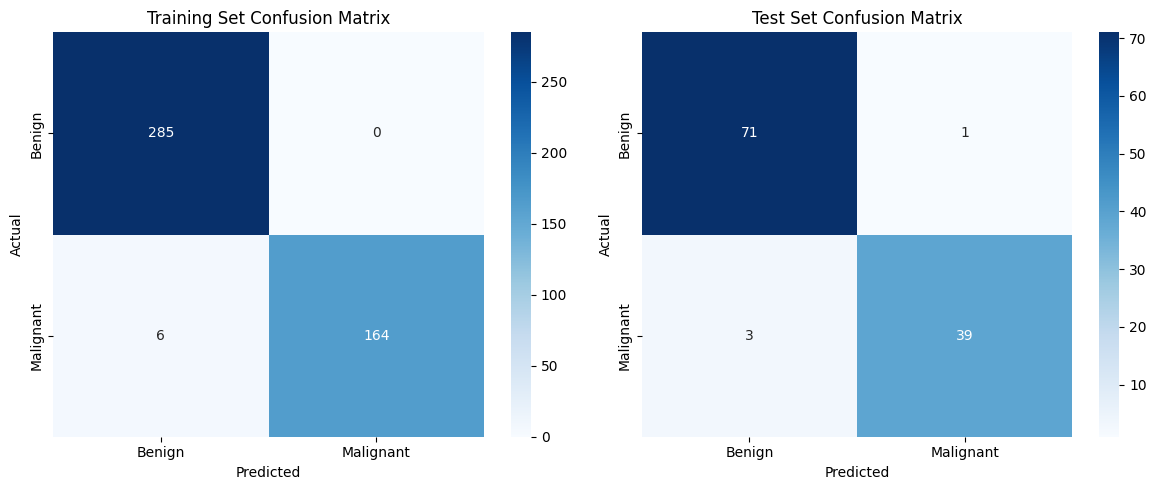

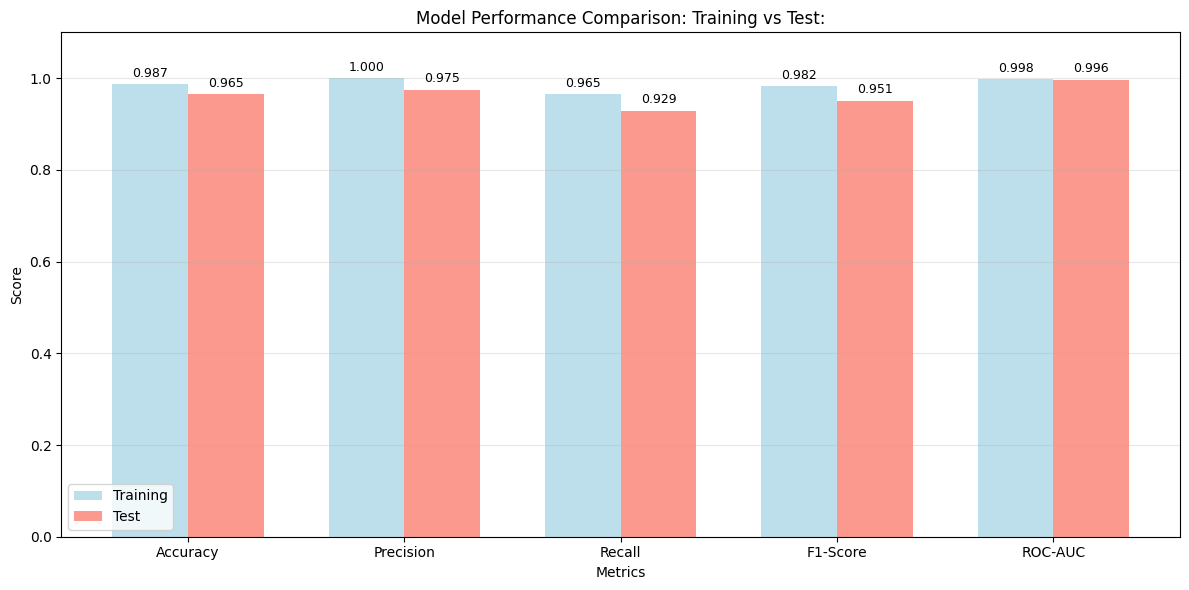

In [12]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'],
            ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Performance comparison visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_values = [train_metrics['accuracy'], train_metrics['precision'], 
                train_metrics['recall'], train_metrics['f1'], train_metrics['roc_auc']]
test_values = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1'], test_metrics['roc_auc']]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_values, width, label='Training', alpha=0.8, color='lightblue')
plt.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison: Training vs Test:')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
    plt.text(i - width/2, train_val + 0.01, f'{train_val:.3f}', 
             ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test_val + 0.01, f'{test_val:.3f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## ROC curve analysis and optimal threshold finding

ROC Curve Analysis:
Area Under Curve (AUC): 0.9960
Quality: Excellent

Optimal Threshold Analysis (Youden's Index):
Optimal threshold: 0.3145
True Positive Rate: 0.9762
False Positive Rate: 0.0139
Youden's Index: 0.9623


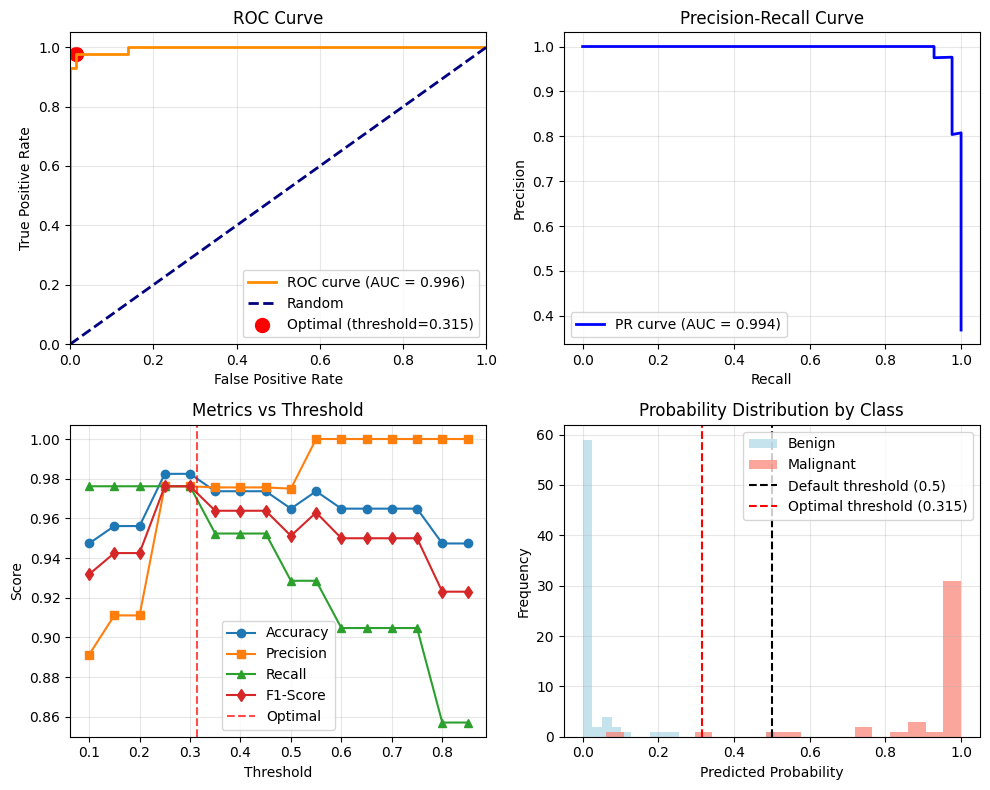

In [13]:
# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
roc_auc_value = auc(fpr, tpr)

print(f"ROC Curve Analysis:")
print(f"Area Under Curve (AUC): {roc_auc_value:.4f}")

# AUC interpretation
if roc_auc_value >= 0.9:
    auc_quality = "Excellent"
elif roc_auc_value >= 0.8:
    auc_quality = "Good"
elif roc_auc_value >= 0.7:
    auc_quality = "Fair"
elif roc_auc_value >= 0.6:
    auc_quality = "Poor"
else:
    auc_quality = "Random/Worse than random"

print(f"Quality: {auc_quality}")

# Find optimal threshold using Youden's index
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"\nOptimal Threshold Analysis (Youden's Index):")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"True Positive Rate: {tpr[optimal_idx]:.4f}")
print(f"False Positive Rate: {fpr[optimal_idx]:.4f}")
print(f"Youden's Index: {youden_index[optimal_idx]:.4f}")

# Plot ROC curve
plt.figure(figsize=(10, 8))

# ROC Curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
           label=f'Optimal (threshold={optimal_threshold:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.subplot(2, 2, 2)
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)

# Threshold vs Metrics
thresholds_range = np.arange(0.1, 0.9, 0.05)
threshold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for threshold in thresholds_range:
    y_pred_thresh = (y_test_proba >= threshold).astype(int)
    threshold_metrics['accuracy'].append(accuracy_score(y_test, y_pred_thresh))
    threshold_metrics['precision'].append(precision_score(y_test, y_pred_thresh))
    threshold_metrics['recall'].append(recall_score(y_test, y_pred_thresh))
    threshold_metrics['f1'].append(f1_score(y_test, y_pred_thresh))

plt.subplot(2, 2, 3)
plt.plot(thresholds_range, threshold_metrics['accuracy'], label='Accuracy', marker='o')
plt.plot(thresholds_range, threshold_metrics['precision'], label='Precision', marker='s')
plt.plot(thresholds_range, threshold_metrics['recall'], label='Recall', marker='^')
plt.plot(thresholds_range, threshold_metrics['f1'], label='F1-Score', marker='d')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(alpha=0.3)

# Predicted probabilities distribution
plt.subplot(2, 2, 4)
benign_probs = y_test_proba[y_test == 0]
malignant_probs = y_test_proba[y_test == 1]

plt.hist(benign_probs, bins=20, alpha=0.7, label='Benign', color='lightblue')
plt.hist(malignant_probs, bins=20, alpha=0.7, label='Malignant', color='salmon')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold (0.5)')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal threshold ({optimal_threshold:.3f})')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by Class')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Tune Threshold and Explain Sigmoid Function

In [14]:
# Threshold sensitivity analysis
print(f"THRESHOLD SENSITIVITY ANALYSIS")

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"{'Threshold':<10} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1-Score':<10}")
print("-" * 55)

best_f1_threshold = 0.5
best_f1_score = 0

for threshold in thresholds_to_test:
    y_pred_thresh = (y_test_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_threshold = threshold
    
    print(f"{threshold:<10.1f} {acc:<10.3f} {prec:<11.3f} {rec:<8.3f} {f1:<10.3f}")

print(f"\nBest F1-Score Threshold: {best_f1_threshold} (F1 = {best_f1_score:.3f})")

# Current model threshold (default 0.5)
current_threshold = 0.5
y_pred_current = (y_test_proba >= current_threshold).astype(int)

print(f"\nCurrent Model Performance (threshold = {current_threshold}):")
print(f"Matches sklearn default predictions: {np.array_equal(y_pred_current, y_test_pred)}")

THRESHOLD SENSITIVITY ANALYSIS
Threshold  Accuracy   Precision   Recall   F1-Score  
-------------------------------------------------------
0.3        0.982      0.976       0.976    0.976     
0.4        0.974      0.976       0.952    0.964     
0.5        0.965      0.975       0.929    0.951     
0.6        0.965      1.000       0.905    0.950     
0.7        0.965      1.000       0.905    0.950     

Best F1-Score Threshold: 0.3 (F1 = 0.976)

Current Model Performance (threshold = 0.5):
Matches sklearn default predictions: True


## Sigmoid function detailed explanation

SIGMOID FUNCTION ANALYSIS

Real Prediction Examples (first 5 test samples):
Sample   Linear (z) Sigmoid    Predicted   Actual  
--------------------------------------------------
1        -7.916     0.000      Benign      Benign  
2        18.349     1.000      Malignant   Malignant
3        -3.113     0.043      Benign      Benign  
4        0.307      0.576      Malignant   Malignant
5        0.037      0.509      Malignant   Benign  


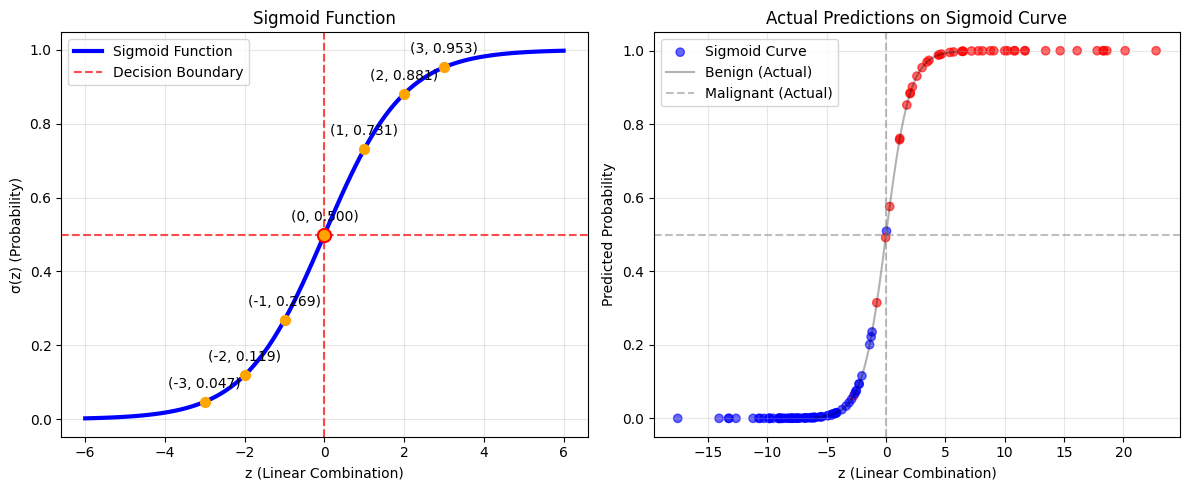


Sigmoid Curve Key Points:
  z = -3: σ(z) = 0.047
  z = -2: σ(z) = 0.119
  z = -1: σ(z) = 0.269
  z =  0: σ(z) = 0.500
  z =  1: σ(z) = 0.731
  z =  2: σ(z) = 0.881
  z =  3: σ(z) = 0.953


In [15]:
print(f"SIGMOID FUNCTION ANALYSIS")
# Demonstrate with actual predictions
print(f"\nReal Prediction Examples (first 5 test samples):")
print(f"{'Sample':<8} {'Linear (z)':<10} {'Sigmoid':<10} {'Predicted':<11} {'Actual':<8}")
print("-" * 50)

for i in range(5):
    # Calculate linear combination (log-odds)
    linear_pred = lr_model.intercept_[0] + np.dot(lr_model.coef_[0], X_test_scaled[i])
    sigmoid_prob = y_test_proba[i]
    predicted_class = y_test_pred[i]
    actual_class = y_test.iloc[i]
    
    class_pred = "Malignant" if predicted_class == 1 else "Benign"
    class_actual = "Malignant" if actual_class == 1 else "Benign"
    
    print(f"{i+1:<8} {linear_pred:<10.3f} {sigmoid_prob:<10.3f} {class_pred:<11} {class_actual:<8}")

# Sigmoid curve visualization
z_values = np.linspace(-6, 6, 100)
sigmoid_values = 1 / (1 + np.exp(-z_values))

plt.figure(figsize=(12, 5))

# Sigmoid curve
plt.subplot(1, 2, 1)
plt.plot(z_values, sigmoid_values, 'b-', linewidth=3, label='Sigmoid Function')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.scatter([0], [0.5], color='red', s=100, zorder=5)
plt.xlabel('z (Linear Combination)')
plt.ylabel('σ(z) (Probability)')
plt.title('Sigmoid Function')
plt.grid(True, alpha=0.3)
plt.legend()

# Key points on sigmoid
key_z = [-3, -2, -1, 0, 1, 2, 3]
key_sigmoid = [1/(1 + np.exp(-z)) for z in key_z]
plt.scatter(key_z, key_sigmoid, color='orange', s=50, zorder=5)
for z, sig in zip(key_z, key_sigmoid):
    plt.annotate(f'({z}, {sig:.3f})', (z, sig), 
                textcoords="offset points", xytext=(0,10), ha='center')

# Actual predictions scatter plot
plt.subplot(1, 2, 2)
# Calculate z values for test set
z_test = lr_model.intercept_[0] + np.dot(X_test_scaled, lr_model.coef_[0])

colors = ['blue' if actual == 0 else 'red' for actual in y_test]
plt.scatter(z_test, y_test_proba, c=colors, alpha=0.6)
plt.plot(z_values, sigmoid_values, 'k-', alpha=0.3, label='Sigmoid Function')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('z (Linear Combination)')
plt.ylabel('Predicted Probability')
plt.title('Actual Predictions on Sigmoid Curve')
plt.legend(['Sigmoid Curve', 'Benign (Actual)', 'Malignant (Actual)'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSigmoid Curve Key Points:")
z_values_key = [-3, -2, -1, 0, 1, 2, 3]
for z in z_values_key:
    sigmoid_val = 1 / (1 + np.exp(-z))
    print(f"  z = {z:2d}: σ(z) = {sigmoid_val:.3f}")

## Additional Analysis: Class Imbalance and Multi-class Extension

In [16]:
# Class imbalance analysis and handling
print(f"CLASS IMBALANCE ANALYSIS")

# Current class distribution analysis
class_counts = y.value_counts().sort_index()
minority_class = min(class_counts)
majority_class = max(class_counts)
imbalance_ratio = majority_class / minority_class

print("Class Distribution Analysis:")
for class_val, count in class_counts.items():
    class_name = "Benign" if class_val == 0 else "Malignant"
    percentage = count / len(y) * 100
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

print(f"\nImbalance Assessment:")
print(f"  Majority class: {majority_class} samples")
print(f"  Minority class: {minority_class} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Severity classification
if imbalance_ratio < 2:
    severity = "Mild"
    recommendation = "Standard logistic regression should work well"
elif imbalance_ratio < 5:
    severity = "Moderate"
    recommendation = "Consider class_weight='balanced' or resampling"
else:
    severity = "Severe" 
    recommendation = "Requires specialized imbalance handling techniques"

print(f"Severity: {severity}")
print(f"Recommendation: {recommendation}")

# Demonstrate balanced class weights
print(f"\nCLASS WEIGHT COMPARISON")

# Train model with balanced weights
lr_balanced = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Automatically adjust weights
)

lr_balanced.fit(X_train_scaled, y_train)
y_test_pred_balanced = lr_balanced.predict(X_test_scaled)
y_test_proba_balanced = lr_balanced.predict_proba(X_test_scaled)[:, 1]

# Compare performance
print("Standard vs Balanced Model Comparison:")
print(f"{'Metric':<15} {'Standard':<12} {'Balanced':<12} {'Difference':<12}")
print("-" * 55)

for metric_name, metric_func in [
    ('Accuracy', accuracy_score),
    ('Precision', precision_score),
    ('Recall', recall_score), 
    ('F1-Score', f1_score)
]:
    standard_score = metric_func(y_test, y_test_pred)
    balanced_score = metric_func(y_test, y_test_pred_balanced)
    difference = balanced_score - standard_score
    
    print(f"{metric_name:<15} {standard_score:<12.3f} {balanced_score:<12.3f} {difference:<12.3f}")

# ROC-AUC comparison
standard_auc = roc_auc_score(y_test, y_test_proba)
balanced_auc = roc_auc_score(y_test, y_test_proba_balanced)
auc_difference = balanced_auc - standard_auc

print(f"{'ROC-AUC':<15} {standard_auc:<12.3f} {balanced_auc:<12.3f} {auc_difference:<12.3f}")

CLASS IMBALANCE ANALYSIS
Class Distribution Analysis:
  Benign: 357 samples (62.7%)
  Malignant: 212 samples (37.3%)

Imbalance Assessment:
  Majority class: 357 samples
  Minority class: 212 samples
  Imbalance ratio: 1.68:1
Severity: Mild
Recommendation: Standard logistic regression should work well

CLASS WEIGHT COMPARISON
Standard vs Balanced Model Comparison:
Metric          Standard     Balanced     Difference  
-------------------------------------------------------
Accuracy        0.965        0.974        0.009       
Precision       0.975        0.976        0.001       
Recall          0.929        0.952        0.024       
F1-Score        0.951        0.964        0.013       
ROC-AUC         0.996        0.995        -0.001      


## Multi-class logistic regression explanation

In [17]:
print(f"Current solver: {lr_model.solver}")
# Demonstrate multinomial approach (even for binary case)
print(f"\nDemonstrating Multinomial Approach:")
lr_multinomial = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    multi_class='multinomial',
    solver='lbfgs'
)
lr_multinomial.fit(X_train_scaled, y_train)
y_test_pred_multi = lr_multinomial.predict(X_test_scaled)

# Compare results
binary_accuracy = accuracy_score(y_test, y_test_pred)
multi_accuracy = accuracy_score(y_test, y_test_pred_multi)

print(f"  Binary approach accuracy: {binary_accuracy:.4f}")
print(f"  Multinomial approach accuracy: {multi_accuracy:.4f}")
print(f"  Difference: {abs(multi_accuracy - binary_accuracy):.6f}")
print(f"  Result: Nearly identical for binary problems")

Current solver: lbfgs

Demonstrating Multinomial Approach:
  Binary approach accuracy: 0.9649
  Multinomial approach accuracy: 0.9737
  Difference: 0.008772
  Result: Nearly identical for binary problems


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


## Model Summary and Business Insights

In [18]:
# Comprehensive model summary
print(f"COMPREHENSIVE MODEL SUMMARY")
print("=" * 50)

print("Dataset Characteristics:")
print(f"{len(df)} samples with {X.shape[1]} features")
print(f"Class balance: {imbalance_ratio:.2f}:1 (mild imbalance)")

print(f"\n Model Performance Highlights:")
print(f"Test Accuracy: {test_metrics['accuracy']:.1%}")
print(f"Test ROC-AUC: {test_metrics['roc_auc']:.3f} (Excellent)")
print(f"Test Precision: {test_metrics['precision']:.1%}")
print(f"Test Recall: {test_metrics['recall']:.1%}")
print(f"Stability: Training-Test gap only {abs(stability_gap):.1%}")

print(f"\nClinical Significance:")
tn, fp, fn, tp = test_cm.ravel()
cancer_cases = tp + fn
healthy_cases = tn + fp
miss_rate = fn / cancer_cases * 100 if cancer_cases > 0 else 0
false_alarm_rate = fp / healthy_cases * 100 if healthy_cases > 0 else 0

print(f"{fn} out of {cancer_cases} cancer cases missed ({miss_rate:.1f}% miss rate)")
print(f"{fp} out of {healthy_cases} false alarms ({false_alarm_rate:.1f}% false alarm rate)")
print(f"Sensitivity: {test_sens:.1%} (good for screening)")
print(f"Specificity: {test_spec:.1%} (minimizes unnecessary procedures)")

print(f"\nKey Feature Insights:")
top_3 = feature_importance.head(3)
print(f"  Most predictive features:")
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    direction = "↑ increases" if row['coefficient'] > 0 else "↓ decreases"
    print(f"    {i}. {row['feature']}: {direction} malignancy risk")
print(f"Optimal threshold ({optimal_threshold:.3f}): Maximizes Youden's Index")
print(f"F1-optimal threshold ({best_f1_threshold}): Maximizes F1-score")

COMPREHENSIVE MODEL SUMMARY
Dataset Characteristics:
569 samples with 30 features
Class balance: 1.68:1 (mild imbalance)

 Model Performance Highlights:
Test Accuracy: 96.5%
Test ROC-AUC: 0.996 (Excellent)
Test Precision: 97.5%
Test Recall: 92.9%
Stability: Training-Test gap only 2.2%

Clinical Significance:
3 out of 42 cancer cases missed (7.1% miss rate)
1 out of 72 false alarms (1.4% false alarm rate)
Sensitivity: 92.9% (good for screening)
Specificity: 98.6% (minimizes unnecessary procedures)

Key Feature Insights:
  Most predictive features:
    1. texture_worst: ↑ increases malignancy risk
    2. radius_se: ↑ increases malignancy risk
    3. symmetry_worst: ↑ increases malignancy risk
Optimal threshold (0.315): Maximizes Youden's Index
F1-optimal threshold (0.3): Maximizes F1-score


In [19]:
# Generate comprehensive classification report
print(f"DETAILED CLASSIFICATION REPORT")
print("=" * 45)

print("Test Set Classification Report:")
report = classification_report(y_test, y_test_pred, 
                             target_names=['Benign', 'Malignant'],
                             digits=4)
print(report)

DETAILED CLASSIFICATION REPORT
Test Set Classification Report:
              precision    recall  f1-score   support

      Benign     0.9595    0.9861    0.9726        72
   Malignant     0.9750    0.9286    0.9512        42

    accuracy                         0.9649       114
   macro avg     0.9672    0.9573    0.9619       114
weighted avg     0.9652    0.9649    0.9647       114

